<a href="https://www.kaggle.com/code/mehmet0sahinn/emotion-classifier-w-distilbert?scriptVersionId=253940146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1- Install Dependencies

In [1]:
!pip install -q transformers datasets evaluate --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


# 2- Load the Dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

# 3- EDA & Data Preprocessing

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
print("Length of train_ds:", len(train_ds))
print("Column names of train_ds:", train_ds.column_names)

Length of train_ds: 16000
Column names of train_ds: ['text', 'label']


In [6]:
# first 5 row with DataFrame format
import pandas as pd

df = pd.DataFrame(emotions["train"][:])
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# 4- Data Visualization

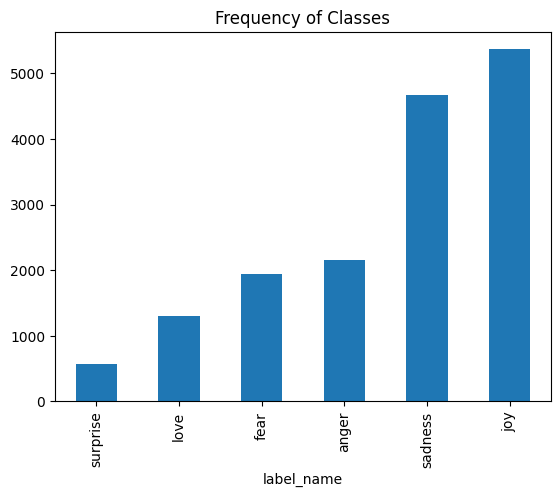

In [8]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.bar()
plt.title("Frequency of Classes")
plt.show()

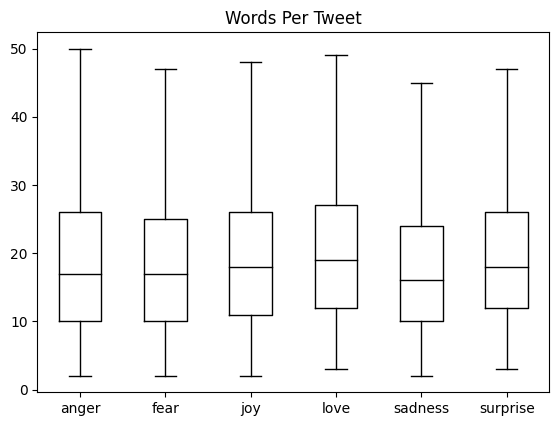

In [9]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", 
           by="label_name", 
           grid=False, 
           showfliers=False, 
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

# 5- Tokenization

## i- Character Tokenization

In [10]:
text = "Start wide, expand further, and never look back."

# split the sentence to the character tokens
tokenized_text = list(text)
print(tokenized_text)

['S', 't', 'a', 'r', 't', ' ', 'w', 'i', 'd', 'e', ',', ' ', 'e', 'x', 'p', 'a', 'n', 'd', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'a', 'n', 'd', ' ', 'n', 'e', 'v', 'e', 'r', ' ', 'l', 'o', 'o', 'k', ' ', 'b', 'a', 'c', 'k', '.']


In [11]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, ',': 1, '.': 2, 'S': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'h': 10, 'i': 11, 'k': 12, 'l': 13, 'n': 14, 'o': 15, 'p': 16, 'r': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22}


In [12]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[3, 18, 4, 17, 18, 0, 21, 11, 7, 8, 1, 0, 8, 22, 16, 4, 14, 7, 0, 9, 19, 17, 18, 10, 8, 17, 1, 0, 4, 14, 7, 0, 14, 8, 20, 8, 17, 0, 13, 15, 15, 12, 0, 5, 4, 6, 12, 2]


## ii- One Hot Encoding with Torch

In [13]:
import torch
import torch.nn.functional as F

# Converting inputs into tensor
input_ids = torch.tensor(input_ids)

one_hot_encoding = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encoding.shape

torch.Size([48, 23])

In [14]:
print(f"Token:{tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-Hot Encoding: {one_hot_encoding[0]}")

Token:S
Tensor index: 3
One-Hot Encoding: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## iii- Word Tokeniziation

In [15]:
tokenized_text = text.split()
print(tokenized_text)

['Start', 'wide,', 'expand', 'further,', 'and', 'never', 'look', 'back.']


## iv- Subword Tokenization

In [16]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2707, 2898, 1010, 7818, 2582, 1010, 1998, 2196, 2298, 2067, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [18]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'start', 'wide', ',', 'expand', 'further', ',', 'and', 'never', 'look', 'back', '.', '[SEP]']


In [19]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] start wide, expand further, and never look back. [SEP]'

## v- Attributes of Tokenizer

In [20]:
tokenizer.vocab_size

30522

In [21]:
tokenizer.model_max_length

512

## vi- Tokenize the Entire DataSet

In [22]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

In [23]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## vii- Padding for Tokenized Inputs

In [24]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

2025-08-03 08:01:09.803031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754208070.163237      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754208070.267009      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
pd.DataFrame(emotions_encoded["train"]).head()

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102]","[1, 1, 1, 1, 1, 1, 1]"
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 102]","[1, 1, 1, 1, 1, 1, 1, 1]"


# 6- Model Training

In [26]:
from transformers  import AutoModelForSequenceClassification

num_labels = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                          num_labels=num_labels).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# 7- Login HuggingFace

In [28]:
from kaggle_secrets import UserSecretsClient 
from huggingface_hub import login

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("hf_token")

login(token=hf_token)

# 8- Training Arguments

In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="distilbert-sentiment-analysis",
    num_train_epochs=4, 
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = False,
    report_to = "none"    
)

In [30]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = tokenizer
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.220300,0.919000
2,No log,0.160752,0.934000
3,No log,0.144157,0.938500
4,0.273200,0.140756,0.937500


TrainOutput(global_step=500, training_loss=0.273184814453125, metrics={'train_runtime': 211.1797, 'train_samples_per_second': 303.059, 'train_steps_per_second': 2.368, 'total_flos': 1000961945243136.0, 'train_loss': 0.273184814453125, 'epoch': 4.0})

# 9- Model Evaluation

In [32]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [33]:
preds_output.metrics

{'test_loss': 0.1407560557126999,
 'test_accuracy': 0.9375,
 'test_runtime': 2.1012,
 'test_samples_per_second': 951.845,
 'test_steps_per_second': 7.615}

## Confusion Matrix

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = "true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=labels)
    disp.plot(cmap="Blues", values_format = ".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

In [35]:
y_valid = np.array(emotions_encoded["validation"]["label"])
labels = emotions["train"].features["label"].names

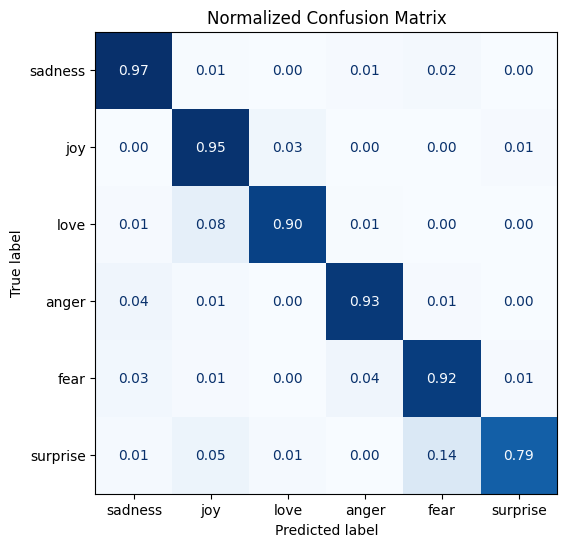

In [36]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [37]:
#trainer.push_to_hub(commit_message="Training has been completed successfully!")

# 10- Model Prediction

In [38]:
from transformers import pipeline

model_id = "mehmet0sahinn/distilbert-sentiment-analysis"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [39]:
custom_text = "I hate smoking cigarettes in the morning."

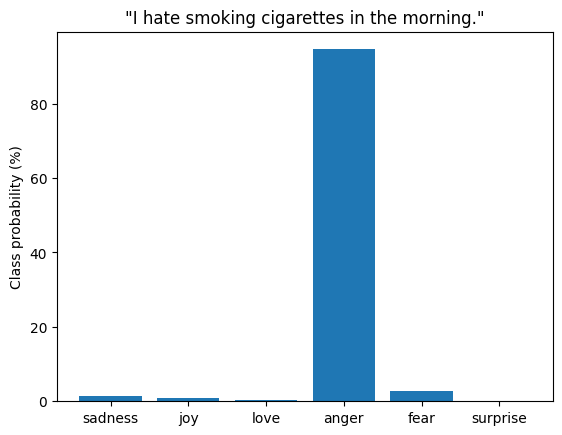

In [40]:
preds = classifier(custom_text, return_all_scores = True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()